# PCA

This notebook visualizes and explains PCA.
Lets look at how the algorithm behaves on MNIST

In [1]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.datasets import fetch_openml
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def styleset():
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

styleset()

In [3]:
mnist_data, mnist_labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, data_home='data')
mnist_data /= mnist_data.max()  # divide by 255 to get in [0,1]

In [4]:
pca = PCA(n_components=mnist_data.shape[1],
          random_state=42)
embeddings = pca.fit_transform(mnist_data)

Lets look at some of the PCAs -- two at a time

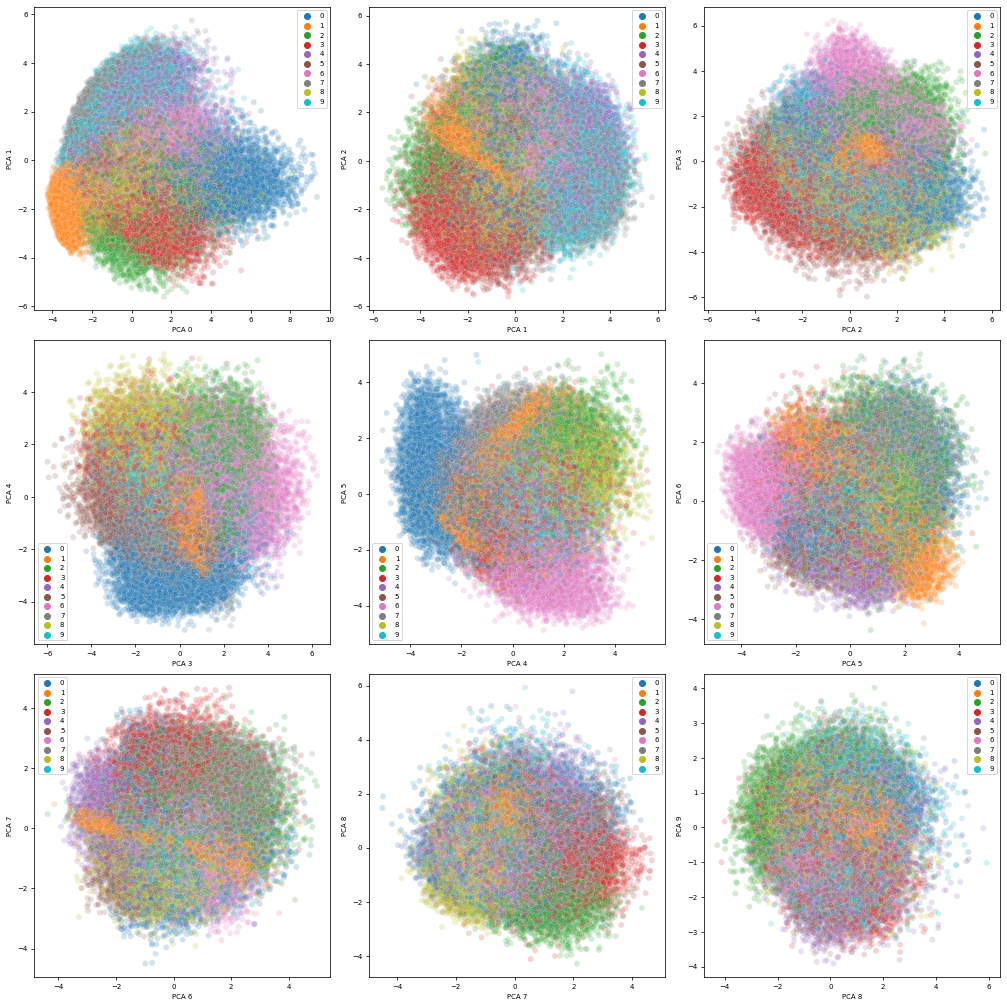

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))

k = 0
bound = np.abs(pca.components_)[:9, :].max() # need for visualization
for i in range(3):
    for j in range(3):
        _ = sns.scatterplot(x=embeddings[:,k], 
                            y=embeddings[:,k+1], 
                            hue=mnist_labels, 
                            hue_order=np.unique(mnist_labels), 
                            ax=ax[i, j], 
                            alpha=0.2)
        ax[i, j].set_xlabel('PCA {}'.format(k))
        ax[i, j].set_ylabel('PCA {}'.format(k+1))
        k += 1
fig.tight_layout()

Remember that PCA is learning a linear function of the data.

Suppose you have data $X_1, ... X_N$ where $X_i \in \mathbb{R}^D$. We think of this as a matrix $X \in \mathbb{R}^{N \times D}$.

Our PCA is learning a linear transformation AKA matrix (lets ignore how for now): 

$$W \in \mathbb{R}^{D \times D}$$

And we can go from $X \in \mathbb{R}^{N \times D}$ to PCA space $emb \in \mathbb{R}^{N \times D}$  via:

$$emb = (X - \mu_X)W$$

Where $\mu_X \in \mathbb{R}^{D}$ is the featurewise mean of $X$

In [6]:
assert np.allclose(embeddings, (mnist_data - pca.mean_) @ pca.components_.T)
assert np.allclose(mnist_data.mean(0), pca.mean_)

What does our principle axis look like? Lets look at the top 24

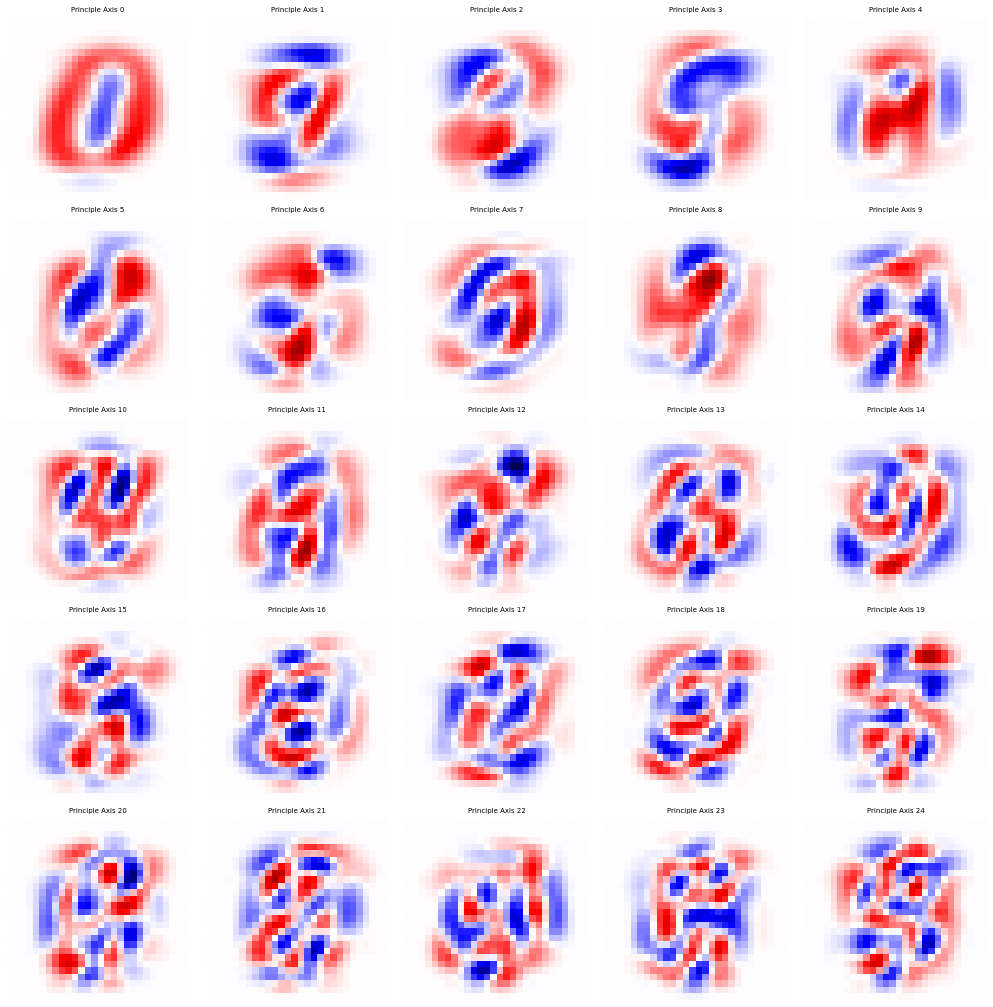

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))

k = 0
bound = np.abs(pca.components_)[:25, :].max() # need for visualization
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(pca.components_[k].reshape(28, 28), cmap='seismic', vmin=-bound, vmax=bound)
        ax[i, j].set_title('Principle Axis {}'.format(k))
        ax[i, j].axis('off')
        k += 1
fig.tight_layout()

Now lets describe how to compute $W$. Recall that we can think of our data as a matrix $X \in \mathbb{R}^{N \times D}$.

Suppose that the column-wise mean is $0$ (we can just subtract it off in the beginning). 

Then we can do a *Singular Value Decomposition* of $X$

We get: 
$$X = U\Sigma V^T$$

It turns out that $W=V$

In [8]:
# create the dataset
small_test_data = mnist_data[:5000] # faster computations
small_test_data_centered = small_test_data - small_test_data.mean(0) # center
labels = mnist_labels[:5000]

# run SVD
u, s, vt = np.linalg.svd(small_test_data_centered, full_matrices=False)

Lets check $X = U\Sigma V^T$

In [9]:
assert np.allclose(small_test_data_centered, (u @ np.diag(s) @ vt))

In [10]:
# sklearn does a correction for reproducibility:
# https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/sklearn/decomposition/_pca.py#L494
# columns of u, rows of v
max_abs_cols = np.argmax(np.abs(u), axis=0)
signs = np.sign(u[max_abs_cols, range(u.shape[1])])
u *= signs
vt *= signs[:, np.newaxis]

We verify that Sklearn is doing SVD (plus an additional step for reproducibility)

In [11]:
pca_long_form = (small_test_data_centered @ vt.T)
pca_short_form = PCA(n_components=mnist_data.shape[1], random_state=42).fit_transform(small_test_data)
assert np.allclose(pca_long_form, pca_short_form)

We can also compute the eigendecomposition of $X^T X$.

This will give us $P D P^{-1}$

Where $P=V$ and $D_{ii}=\frac{\Sigma_{ii}^2}{N-1}$

Notice $Cov(X) = X^T X$ (since $X$ centered). This has an interesting interpretation:

The eigenvectors/eigenvalues of the covariance matrix correspond to directions in the column space of $X$ which have the highest variation!

In [12]:
cov = (small_test_data_centered.T @ small_test_data_centered)/(5000-1)
D, P = np.linalg.eigh(cov) # w, v

In [13]:
assert np.allclose((P@np.diag(D)@P.T), cov)

In [14]:
assert np.allclose(D[::-1], s**2/(5000-1))
# note this is very similar but differs from pca.explained_variance_ (not sure why)

Verifying that $P$ is the same as $V$. Note that we have to change sign (this is due to minor differences in the algorithms) 

In [15]:
assert np.allclose(P[:,-1], -vt[0])
assert np.allclose(P[:,-2], vt[1])

We can measure the importance of each using the eigenvalues (recall that these are related to singular values $\Sigma$)

The relative importance is $\frac{D_{ii}}{\sum_k D_{kk}}$

To do dimensionality reduction, we just remove the columns of $V$ with the smallest corresponding singular values.

Notice in the visualization below how much variation is due to the first few principle components

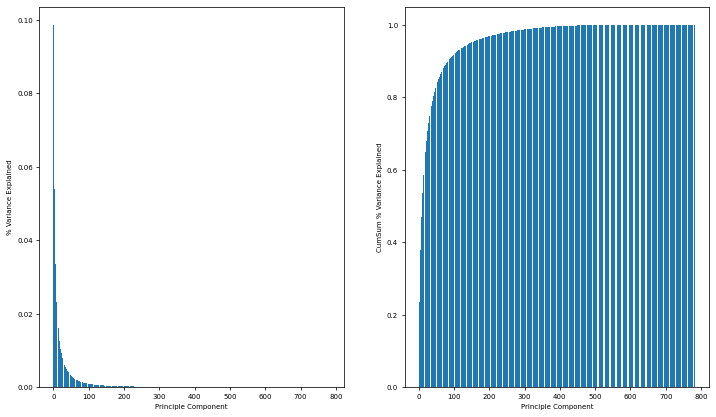

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(12,7))
_ = ax[0].bar(x=np.arange(784), height=D[::-1]/D.sum())
_ = ax[0].set_xlabel('Principle Component')
_ = ax[0].set_ylabel('% Variance Explained')

_ = ax[1].bar(x=np.arange(784), height=(D[::-1]/D.sum()).cumsum())
_ = ax[1].set_xlabel('Principle Component')
_ = ax[1].set_ylabel('CumSum % Variance Explained')

# Note pca.explained_variance_ratio_ differs slightly from D[::-1]/np.sum(D) since D differs from pca.explained_variance_ 
# otherwise the formula is the same
assert np.allclose(pca.explained_variance_ / pca.explained_variance_.sum(), pca.explained_variance_ratio_)

You can see that:

In [17]:
num_pc_needed_80 = np.where((D[::-1]/D.sum()).cumsum()>.80)[0][0]
num_pc_needed_95 = np.where((D[::-1]/D.sum()).cumsum()>.95)[0][0]
print('The top {} PCs explains 80% of the variation'.format(num_pc_needed_80))
print('The top {} PCs explains 95% of the variation'.format(num_pc_needed_95))

The top 42 PCs explains 80% of the variation
The top 147 PCs explains 95% of the variation
